# Clustering European Countries Based on Overall Emission Profiles

The goal of this analysis is to group European countries based on their overall emission characteristics. Instead of simply ranking countries by total CO₂ emissions, we use multidimensional data to identify clusters of countries with similar emission profiles, regardless of their size or absolute values.

### Loading data

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
warnings.filterwarnings("ignore")

In [3]:
data_root = './data/'

df_emissions = pd.read_csv(f"{data_root}co2_emmisions_complicated.csv")
df_gdp = pd.read_csv(f"{data_root}co2-emissions-vs-gdp.csv")
df_pop = pd.read_csv(f"{data_root}world_population.csv")

In [4]:
# Filter df_emissions to Europe
df_emissions_europe = df_emissions[df_emissions['Region'].str.contains("Europe", case=False, na=False)]

# Filter df_pop to Europe
df_pop_europe = df_pop[df_pop['Continent'] == 'Europe']

#Euro codes
europe_codes = df_pop_europe["CCA3"].unique()

# Filter df_gdp to Europe by codes
df_gdp_europe = df_gdp[df_gdp['Code'].isin(europe_codes)]

#Add Russia
df_russia = df_emissions_europe[df_emissions_europe['Name'].str.contains('Russian Federation', case=False, na=False)].copy()
df_russia['Name'] = df_russia['Name'].replace('Russian Federation', 'Russia')

# Add Ukraine
df_ukraine = df_emissions_europe[df_emissions_europe['Name'].str.contains('Ukraine', case=False, na=False)].copy()

# Add Belarus
df_belarus = df_emissions_europe[df_emissions_europe['Name'].str.contains('Belarus', case=False, na=False)].copy()

# Add Moldova
df_moldova = df_emissions_europe[df_emissions_europe['Name'].str.contains('Moldova', case=False, na=False)].copy()
df_moldova['Name'] = df_moldova['Name'].replace('Moldova, Republic of', 'Moldova')

# Combine all
df_co2_europe = pd.concat([df_emissions_europe, df_russia, df_ukraine, df_belarus, df_moldova]).drop_duplicates()

In [5]:
row = df_co2_europe[df_co2_europe['Name'] == 'Serbia and Montenegro'].copy()

serbia_row = row.copy()
montenegro_row = row.copy()

serbia_row['Country_code'] = 'SRB'
serbia_row['Name'] = 'Serbia'

montenegro_row['Country_code'] = 'MNE'
montenegro_row['Name'] = 'Montenegro'

year_columns = [col for col in df_co2_europe.columns if col.isdigit()]

# Split the CO2 data by 85% and 15% because Serbia is much bigger than Montenegro by area and by population
serbia_row[year_columns] = row[year_columns] * 0.96
montenegro_row[year_columns] = row[year_columns] * 0.04

# Drop the original Serbia and Montenegro row
df_co2_europe = df_co2_europe[df_co2_europe['Name'] != 'Serbia and Montenegro']

# Append the two new rows
df_co2_europe = pd.concat([df_co2_europe, serbia_row, montenegro_row], ignore_index=True)

## Clustering of European Countries by CO2 Emissions and GDP - 2020

First, we will create a scatter plot of countries based on their CO₂ emissions and GDP. Using K-means clustering, we will identify groups of countries with similar emission and economic profiles. This approach will help us uncover patterns to determine whether GDP influences CO₂ emissions and/or if other factors play a significant role.

In [6]:
# function returns WSS score for k values from 1 to kmax
def get_elbow(df, max_cluster=10, plot=True):
    # WSS storage
    wss = []
    
    # Try k from 1 to 10 (you can increase this if needed)
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        kmeans.fit(X)
        wss.append(kmeans.inertia_)  # inertia_ is the WSS
    
    # Plot the Elbow Graph
    plt.plot(range(1, 11), wss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS (Within-cluster Sum of Squares)')
    plt.grid(True)
    plt.show()

    return wss

The function **get_elbow** is a function that uses the Elbow Method to calculate and plot the optimal number of clusters (k) for KMeans clustering. This method helps identify the value of k where adding more clusters doesn't significantly improve the model (i.e., where the "elbow" appears on the WSS curve).
If you'd like to learn more, check out this article:

[Read more about the Elbow Method here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

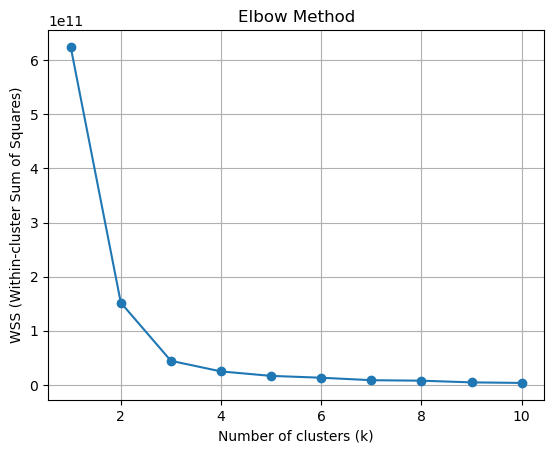

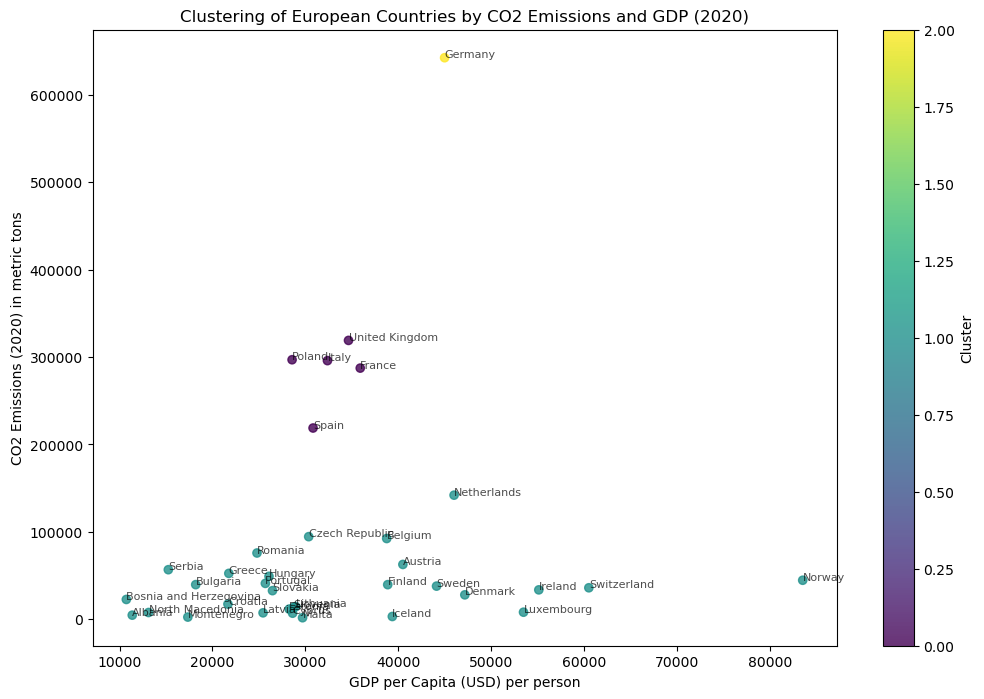

Cluster 0:
          Name  gdp_per_emission  emissions_per_capita
         Spain          0.140962              4.443060
        France          0.124994              4.255960
         Italy          0.109456              5.050722
United Kingdom          0.108619              4.844164
        Poland          0.096258              7.923110


Cluster 1:
                  Name  gdp_per_emission  emissions_per_capita
                 Malta         18.331958              3.088516
               Iceland         12.997232              9.113012
            Montenegro          7.361205              3.960025
            Luxembourg          6.731710             12.806264
                Cyprus          4.210077              5.386997
                Latvia          3.523992              3.681081
               Albania          2.493554              1.640428
               Estonia          2.461641              6.917965
              Slovenia          2.140874              6.114485
             Lit

In [7]:
year = 2020

# Reshape df_co2_europe from wide to long
df_emissions_long = df_co2_europe.melt(
    id_vars=['Region', 'Country_code', 'Name', 'Substance'],
    var_name='Year',
    value_name='Emissions'
)

df_emissions_long['Year'] = pd.to_numeric(df_emissions_long['Year'], errors='coerce')
df_emissions_long = df_emissions_long.dropna(subset=['Year'])
df_emissions_long['Year'] = df_emissions_long['Year'].astype(int)

# Filter for CO2 and selected year
df_emissions_year = df_emissions_long[
    (df_emissions_long['Year'] == year) &
    (df_emissions_long['Substance'].str.lower() == 'co2')
]

# Filter GDP for the same year
df_gdp_year = df_gdp_europe[df_gdp_europe['Year'] == year]

df_merged = df_emissions_year.merge(
    df_gdp_year,
    left_on='Country_code',
    right_on='Code',
    how='inner'
)

# Drop missing values in key columns
df_merged = df_merged.dropna(subset=['Emissions', 'GDP per capita'])

# Dynamically find the per capita emissions column (case insensitive)
per_capita_cols = [col for col in df_merged.columns if 'emissions' in col.lower() and 'per capita' in col.lower()]
if not per_capita_cols:
    raise ValueError("Per capita emissions column not found!")
per_capita_col = per_capita_cols[0]

# Compute helper columns
df_merged['gdp_per_emission'] = df_merged['GDP per capita'] / df_merged['Emissions']
df_merged['emissions_per_capita'] = df_merged[per_capita_col]

# Prepare features for clustering
X = df_merged[['Emissions', 'GDP per capita']]

wss = get_elbow(X, 10, True)

kmeans = KMeans(n_clusters=3, random_state=42)
df_merged['Cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_merged['GDP per capita'],
    df_merged['Emissions'],
    c=df_merged['Cluster'],
    cmap='viridis',
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('GDP per Capita (USD) per person')
plt.ylabel(f'CO2 Emissions ({year}) in metric tons')
plt.title(f'Clustering of European Countries by CO2 Emissions and GDP ({year})')

for _, row in df_merged.iterrows():
    plt.text(row['GDP per capita'], row['Emissions'], row['Name'], fontsize=8, alpha=0.7)
plt.show()

for cluster_id in sorted(df_merged['Cluster'].unique()):
    print(f"Cluster {cluster_id}:")
    cluster_df = df_merged[df_merged['Cluster'] == cluster_id][['Name', 'gdp_per_emission', 'emissions_per_capita']]
    print(cluster_df.sort_values('gdp_per_emission', ascending=False).to_string(index=False))
    print('\n')

### Cluster Summary
#### Cluster 0:
This group contains many smaller or medium-sized European countries with generally higher GDP per unit of CO₂ emissions (higher economic output relative to emissions) and a wide range of per capita emissions, including countries like Malta, Iceland, Luxembourg, Cyprus, and Norway. These countries tend to be more efficient or have smaller absolute emissions but varying per capita impact.

#### Cluster 1:
This cluster groups larger economies like Spain, France, Italy, the UK, and Poland, characterized by moderate GDP per emission ratios and relatively consistent mid-level per capita emissions. These countries have sizeable economies and emissions balanced in a more typical European range.

#### Cluster 2:
Contains only Germany, which stands out with the lowest GDP per emission ratio among clusters but a relatively high per capita emission level, indicating a large economy with significant emissions per capita.

## Clustering based on Efficiency - 2022
Next, we'll do clustering of countries based on efficiency — how much GDP they produce per unit of CO₂ emitted. This gives insight into “green” economies that generate more economic output with less pollution.

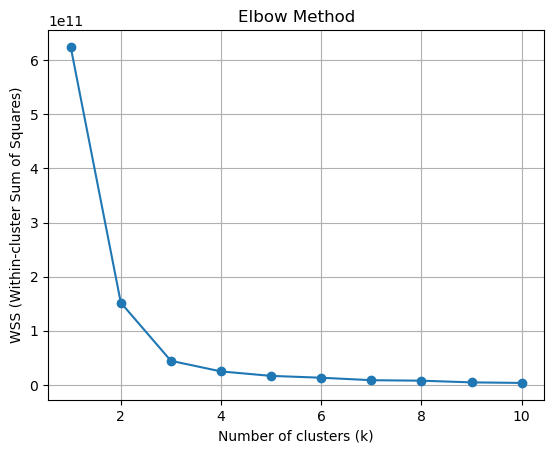

Cluster 0:
                      Name  gdp_per_emission  emissions_per_capita
1                  Austria     113901.289480              0.384481
2                  Belgium      78112.499212              0.536052
3                 Bulgaria      40461.406418              0.508941
4   Bosnia and Herzegovina      43332.297760              0.280227
7                  Germany      78476.888512              0.594414
8                  Denmark     106979.659501              0.473825
11                 Finland      79220.890581              0.513772
12                  France     117642.628835              0.332071
13          United Kingdom      90354.006203              0.425067
14                  Greece      69862.349067              0.361910
15                 Croatia      93683.361299              0.288063
16                 Hungary      83009.004994              0.354803
18                 Iceland     106266.547594              0.396603
19                   Italy     101215.724158       

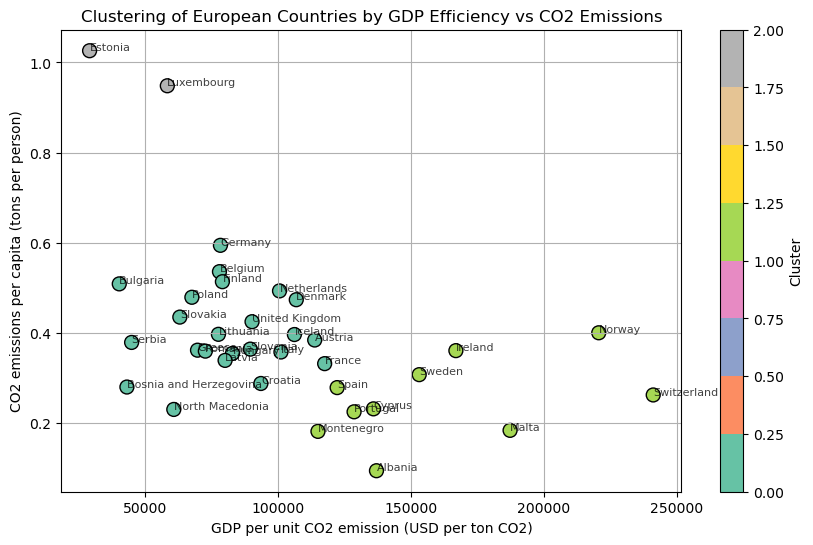

In [8]:
latest_year = 2022

gdp_latest = df_gdp_europe[df_gdp_europe['Year'] == latest_year][['Entity', 'GDP per capita']].rename(columns={'Entity': 'Name'})
pop_latest = df_pop_europe[['Country/Territory', '2022 Population']].rename(columns={'Country/Territory': 'Name', '2022 Population': 'Population'})

year_cols = [str(year) for year in range(1970, 2023)]  # 1970–2022 inclusive

# Sum total emissions for Europe using df_co2_europe
df_co2_europe['total_emissions'] = df_co2_europe[year_cols].sum(axis=1)

# Merge emissions with GDP and population data
df = df_co2_europe.merge(gdp_latest, on='Name', how='inner')
df = df.merge(pop_latest, on='Name', how='inner')

# Calculate total GDP
df['total_gdp'] = df['GDP per capita'] * df['Population']

# GDP per unit CO2 emissions
df['gdp_per_emission'] = df['total_gdp'] / df['total_emissions']

# Emissions per capita
df['emissions_per_capita'] = df['total_emissions'] / df['Population']

features = df[['gdp_per_emission', 'emissions_per_capita']].dropna()
df_clean = df.loc[features.index].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

wss = get_elbow(X, 10, True)

kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

for c in sorted(df_clean['cluster'].unique()):
    print(f"Cluster {c}:")
    print(df_clean[df_clean['cluster'] == c][['Name', 'gdp_per_emission', 'emissions_per_capita']])
    print()

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_clean['gdp_per_emission'], 
    df_clean['emissions_per_capita'], 
    c=df_clean['cluster'], 
    cmap='Set2', 
    s=100, 
    edgecolor='k'
)

plt.title('Clustering of European Countries by GDP Efficiency vs CO2 Emissions')
plt.xlabel('GDP per unit CO2 emission (USD per ton CO2)')
plt.ylabel('CO2 emissions per capita (tons per person)')
plt.colorbar(scatter, label='Cluster')

for i, row in df_clean.iterrows():
    plt.text(row['gdp_per_emission'], row['emissions_per_capita'], row['Name'], fontsize=8, alpha=0.75)

plt.grid(True)
plt.show()


#### Cluster 0: High GDP Efficiency & Low Emissions per Capita
Countries like Switzerland, Norway, and Sweden show very high economic output relative to their CO₂ emissions, while maintaining low emissions per person. These are generally wealthier, developed nations with efficient economies and cleaner energy or better emission controls.

#### Cluster 1: Low GDP Efficiency & High Emissions per Capita
Estonia and Luxembourg fall here, with comparatively low GDP generated per unit of emissions but relatively high emissions per capita. These countries may have carbon-intensive industries or less efficient economies.

#### Cluster 2: Moderate GDP Efficiency & Moderate Emissions per Capita
This largest cluster includes countries like Germany, the UK, Italy, and Poland. They show balanced but moderate economic efficiency in terms of emissions and moderate per-person emissions, reflecting mixed industrial profiles and energy usage patterns.


This clustering highlights groups of countries based on how “green” or efficient their economies are regarding CO₂ emissions, pointing out where improvements might be needed.

Next, we'll create a graph illustrating the percentage change in CO₂ emissions per capita for each country between 2012 and 2022.

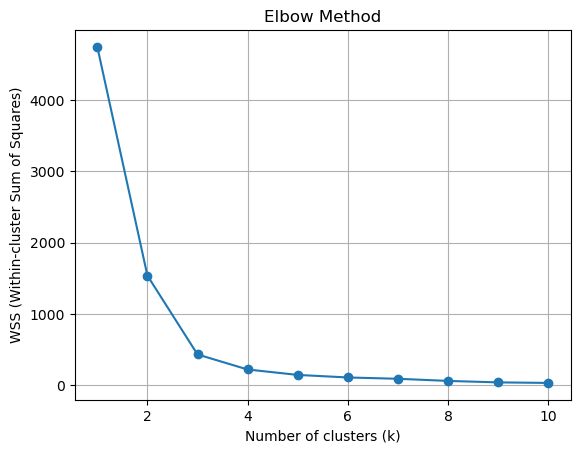

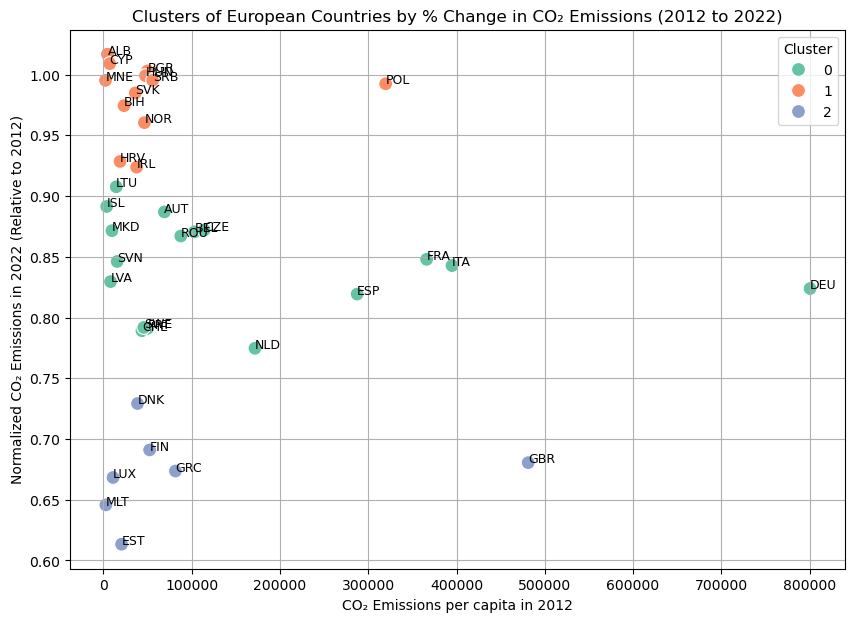

Cluster 0:
AUT, BEL, CHE, CZE, DEU, ESP, FRA, ISL, ITA, LTU, LVA, MKD, NLD, PRT, ROU, SVN, SWE

Cluster 1:
ALB, BGR, BIH, CYP, HRV, HUN, IRL, NOR, POL, SVK, SRB, MNE

Cluster 2:
DNK, EST, FIN, GBR, GRC, LUX, MLT



In [9]:
df_co2_europe = df_co2_europe.rename(columns={'Country_code': 'Code'})

# Country, Code, and emissions for 2012 and 2022
cols_needed = ['Name', 'Code', '2012', '2022']
df_years = df_co2_europe[cols_needed].dropna(subset=['2012', '2022'])

# Calculate percentage CO2 emissions change between 2012 and 2022
df_years['CO2_pct_change'] = ((df_years['2022'] - df_years['2012']) / df_years['2012']) * 100

X = df_years[['CO2_pct_change']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wss = get_elbow(X, 10, True)

kmeans = KMeans(n_clusters=3, random_state=42)
df_years['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot clusters:
# x-axis: CO2 emissions in 2012
# y-axis: normalized CO2 emissions in 2022 (relative to 2012)
df_years['Normalized_2022'] = df_years['2022'] / df_years['2012']

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='2012',
    y='Normalized_2022',
    hue='Cluster',
    palette='Set2',
    data=df_years,
    s=100
)

for _, row in df_years.iterrows():
    plt.text(row['2012'], row['Normalized_2022'], row['Code'], fontsize=9)

plt.title('Clusters of European Countries by % Change in CO₂ Emissions (2012 to 2022)')
plt.xlabel('CO₂ Emissions per capita in 2012')
plt.ylabel('Normalized CO₂ Emissions in 2022 (Relative to 2012)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

for cluster_num in sorted(df_years['Cluster'].unique()):
    countries = df_years[df_years['Cluster'] == cluster_num]['Code'].tolist()
    print(f"Cluster {cluster_num}:")
    print(", ".join(countries))
    print()

Cluster 0: Countries with moderate CO₂ emission changes, mostly stable or slight increases/decreases.

Cluster 1: Countries with larger changes in CO₂ emissions, either bigger increases or decreases.

Cluster 2: Countries with smaller changes in emissions, tending to have more stable or slight decreases.

The graph above illustrates the change in emissions per capita, while the graph below depicts how GDP per capita has evolved over the same period.

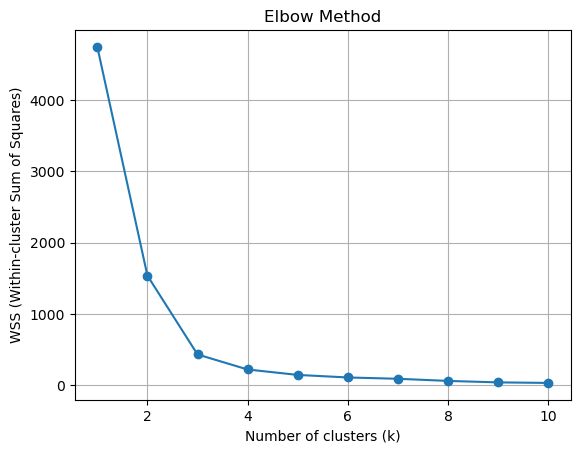

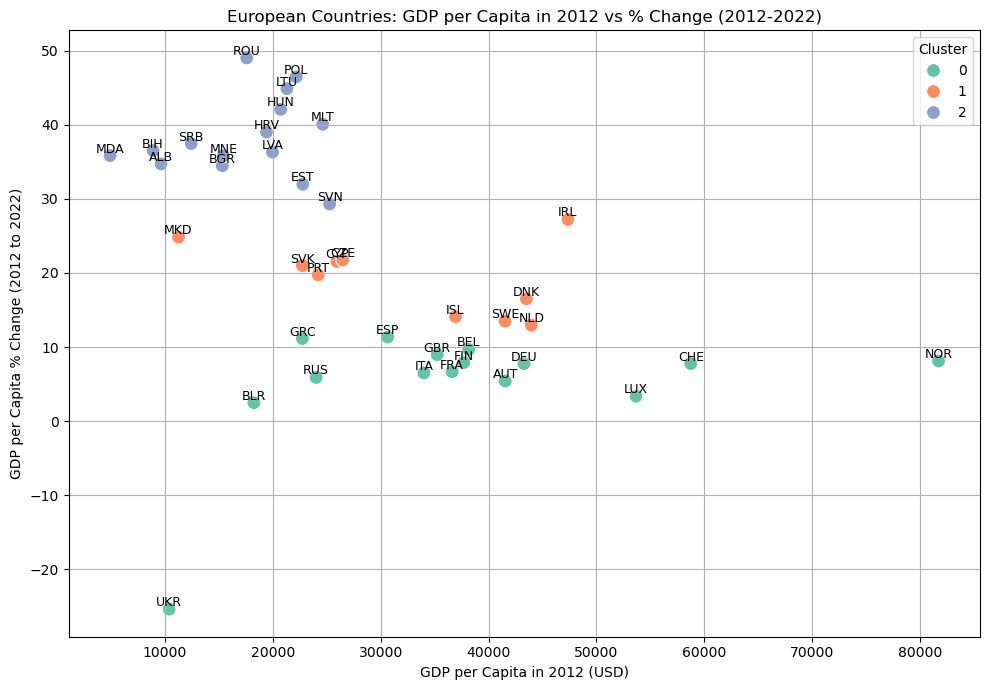

Cluster 0:
AUT, BLR, BEL, FIN, FRA, DEU, GRC, ITA, LUX, NOR, RUS, ESP, CHE, UKR, GBR

Cluster 1:
CYP, CZE, DNK, ISL, IRL, NLD, MKD, PRT, SVK, SWE

Cluster 2:
ALB, BIH, BGR, HRV, EST, HUN, LVA, LTU, MLT, MDA, MNE, POL, ROU, SRB, SVN



In [10]:
df_gdp_filtered = df_gdp_europe[df_gdp_europe['Year'].isin([2012, 2022])]

# Pivot the data to have one row per country, with columns for 2012 and 2022
gdp_pivot = df_gdp_filtered.pivot(index='Entity', columns='Year', values='GDP per capita').reset_index()
gdp_pivot.columns.name = None  # Remove column index name

# Add country codes back (to use in plotting and labeling)
gdp_pivot = gdp_pivot.merge(df_gdp_europe[['Entity', 'Code']].drop_duplicates(), on='Entity', how='left')

# Drop rows with missing GDP values for 2012 or 2022
gdp_pivot = gdp_pivot.dropna(subset=[2012, 2022])

# Rename columns for easier access
gdp_pivot = gdp_pivot.rename(columns={2012: '2012', 2022: '2022'})

gdp_pivot['GDP_pct_change'] = ((gdp_pivot['2022'] - gdp_pivot['2012']) / gdp_pivot['2012']) * 100

# data for clustering on the percentage change only (standardized)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gdp_pivot[['GDP_pct_change']])

# cluster centers at 3 medians of sorted pct change values
sorted_vals = np.sort(gdp_pivot['GDP_pct_change'].values)
n = len(sorted_vals)
initial_centers = np.array([
    np.median(sorted_vals[:n//3]),
    np.median(sorted_vals[n//3:2*n//3]),
    np.median(sorted_vals[2*n//3:])
]).reshape(-1, 1)
initial_centers_scaled = scaler.transform(initial_centers)

wss = get_elbow(X, 10, True)

kmeans = KMeans(n_clusters=3, init=initial_centers_scaled, n_init=1, random_state=42)
gdp_pivot['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='2012',
    y='GDP_pct_change',
    hue='Cluster',
    palette='Set2',
    data=gdp_pivot,
    s=100
)

for _, row in gdp_pivot.iterrows():
    plt.text(row['2012'], row['GDP_pct_change'], row['Code'], fontsize=9, ha='center', va='bottom')

plt.title('European Countries: GDP per Capita in 2012 vs % Change (2012-2022)')
plt.xlabel('GDP per Capita in 2012 (USD)')
plt.ylabel('GDP per Capita % Change (2012 to 2022)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

for cluster in sorted(gdp_pivot['Cluster'].unique()):
    members = gdp_pivot[gdp_pivot['Cluster'] == cluster]['Code'].tolist()
    print(f"Cluster {cluster}:")
    print(", ".join(members))
    print()

Cluster 1: Moderate GDP per capita change between 10% and 20% — steady growth.

Cluster 0: Small or negative change, ranging from -20% up to 10% — mostly stable or slight decline.

Cluster 2: Strong growth with changes over 30% — rapid GDP per capita increase.

So basically, cluster 2 are the fastest-growing economies, cluster 1 are moderate growers, and cluster 0 includes countries with slow growth or slight decline. We can also see an outlier "UKR", the big GDP drop cause is most likely the ongoing (2025) war with Russia.

In the next section, the graph will illustrate how countries’ CO₂ emissions relative to GDP per capita have evolved from 2010 to 2022, highlighting their environmental and economic progress over time.

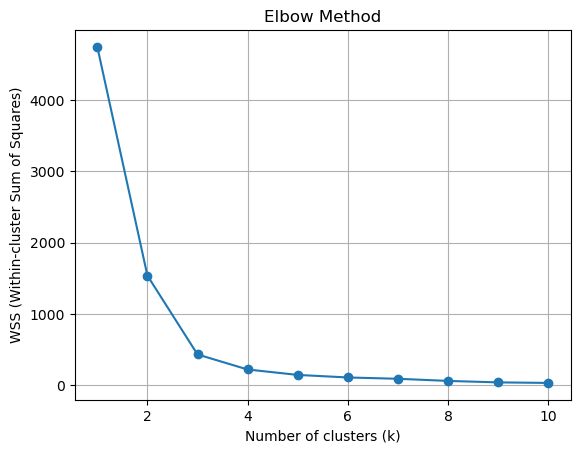

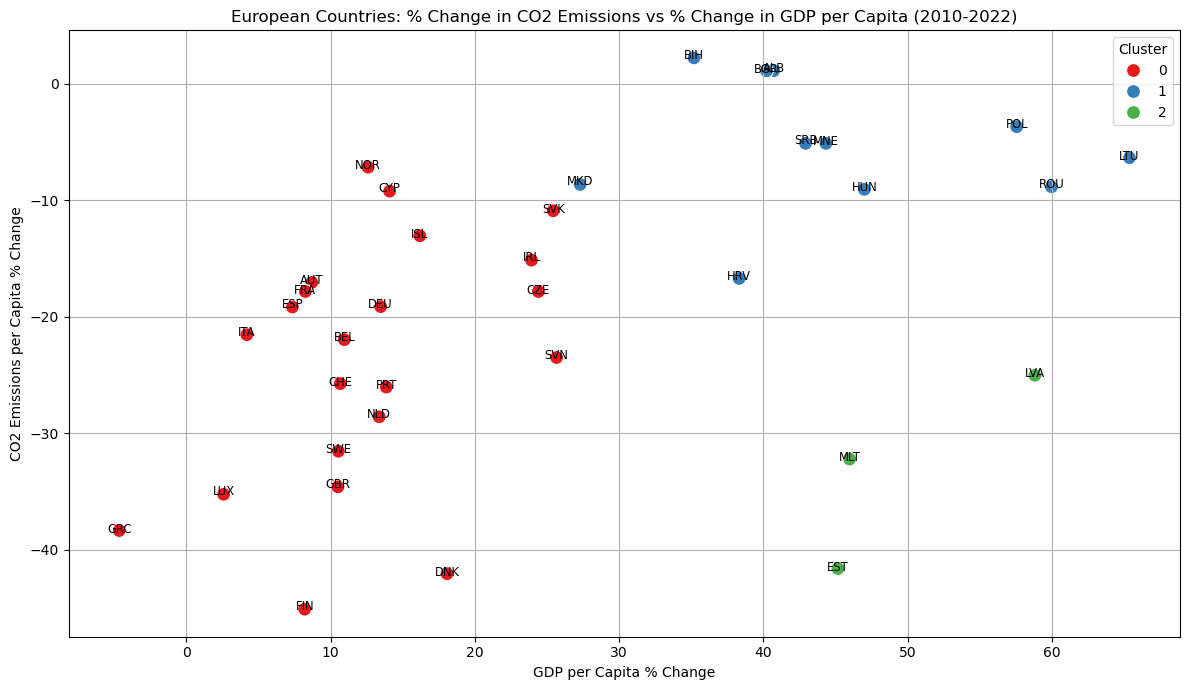

Cluster 0:
AUT, BEL, CHE, CYP, CZE, DEU, DNK, ESP, FIN, FRA, GBR, GRC, IRL, ISL, ITA, LUX, NLD, NOR, PRT, SVK, SVN, SWE

Cluster 1:
ALB, BGR, BIH, HRV, HUN, LTU, MKD, MNE, POL, ROU, SRB

Cluster 2:
EST, LVA, MLT



In [11]:
years = [str(y) for y in range(2010, 2023)]

# Filter for years 2010 and 2022 specifically
df_co2_2010_2022 = df_co2_europe[['Code', 'Name', '2010', '2022']].dropna(subset=['2010', '2022'])
df_gdp_2010_2022 = df_gdp_europe[df_gdp_europe['Year'].isin([2010, 2022])][['Code', 'Year', 'GDP per capita']]

# Pivot GDP data to have years as columns
gdp_pivot = df_gdp_2010_2022.pivot(index='Code', columns='Year', values='GDP per capita').dropna()

# Calculate % change for GDP per capita
gdp_pivot['GDP_pct_change'] = ((gdp_pivot[2022] - gdp_pivot[2010]) / gdp_pivot[2010]) * 100

# Calculate % change for CO2 emissions per capita
df_co2_2010_2022['CO2_pct_change'] = ((df_co2_2010_2022['2022'] - df_co2_2010_2022['2010']) / df_co2_2010_2022['2010']) * 100

# Merge GDP and CO2 % changes on country code
df_merged = pd.merge(
    gdp_pivot[['GDP_pct_change']], 
    df_co2_2010_2022[['Code', 'CO2_pct_change']], 
    left_index=True, 
    right_on='Code',
    how='inner'
)

df_merged = df_merged.dropna(subset=['GDP_pct_change', 'CO2_pct_change'])

wss = get_elbow(X, 10, True)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_merged['Cluster'] = kmeans.fit_predict(df_merged[['GDP_pct_change', 'CO2_pct_change']])

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(
    data=df_merged,
    x='GDP_pct_change',
    y='CO2_pct_change',
    hue='Cluster',
    palette='Set1',
    s=100
)

plt.title('European Countries: % Change in CO2 Emissions vs % Change in GDP per Capita (2010-2022)')
plt.xlabel('GDP per Capita % Change')
plt.ylabel('CO2 Emissions per Capita % Change')
plt.grid(True)
plt.legend(title='Cluster')

# Annotate country codes
offset_y = df_merged['CO2_pct_change'].max() * 0.04
for i, row in df_merged.iterrows():
    stagger = (i % 2) * offset_y
    ax.text(row['GDP_pct_change'], row['CO2_pct_change'] - offset_y - stagger, row['Code'], 
            horizontalalignment='center', size='small', color='black')

plt.tight_layout()
plt.show()

for cluster_num in sorted(df_merged['Cluster'].unique()):
    countries = df_merged[df_merged['Cluster'] == cluster_num]['Code'].tolist()
    print(f"Cluster {cluster_num}:")
    print(", ".join(countries))
    print()

Cluster 0: Countries with mostly stable to moderate GDP growth (-10% to +20%) but significant reductions in CO2 emissions (-25% to -45%). These countries are improving their environmental impact while maintaining economic stability.

Cluster 1: Countries experiencing moderate GDP growth (0% to +30%) with smaller decreases in CO2 emissions (0% to -25%). They show some economic progress along with gradual emissions improvements.

Cluster 2: Countries with strong GDP growth (+30%) but mixed CO2 changes, from moderate increases to decreases (-45% to +5%). Economic growth is high, but CO2 emissions trends vary more widely.

This highlights differing relationships between economic growth and emissions reduction across European countries.